# Iris

This notebook is an example on how to use the VerticaPy Library. We will use the Iris dataset to predict flowers species. You can download the Jupyter Notebook of the study by clicking <a href="iris.ipynb">here</a>. To achieve our goals, we have access to the following data.

<ul>
    <li><b>PetalLengthCm: </b>Petal Length in Cm</li>
    <li><b>PetalWidthCm: </b>Petal Width in Cm</li>
    <li><b>SepalLengthCm: </b>Sepal Length in Cm</li>
    <li><b>SepalWidthCm: </b>Sepal Width in Cm</li>
    <li><b>Species: </b>The Flower Specie (Setosa, Virginica, Versicolor)</li>
</ul>
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from verticapy.learn.datasets import load_iris
iris = load_iris()
iris.head(5)

<object>  Name: iris, Number of rows: 150, Number of columns: 5

## Data Exploration and Preparation

Let's explore the data by displaying descriptive statistics of all the columns.

In [2]:
iris.describe(method = "categorical")

<object>

We need a clear Business Understanding to create the correct features. 

By looking at the descriptive statistics, we can notice that we don't have too much information about the features. The only interesting features we could create are ratios. Indeed, different flower types will have different proportions. 

Besides, we need to use the One Hot Encoder on the 'Species' to get information about each individual specie.

In [3]:
iris["Species"].get_dummies(drop_first = False).eval(
    "ratio_pwl", "PetalWidthCm / PetalLengthCm").eval(
    "ratio_swl", "SepalWidthCm / SepalLengthCm")

<object>  Name: iris, Number of rows: 150, Number of columns: 10

We can draw the correlation matrix (Pearson coeff) of the new features to see if there are some linear links.

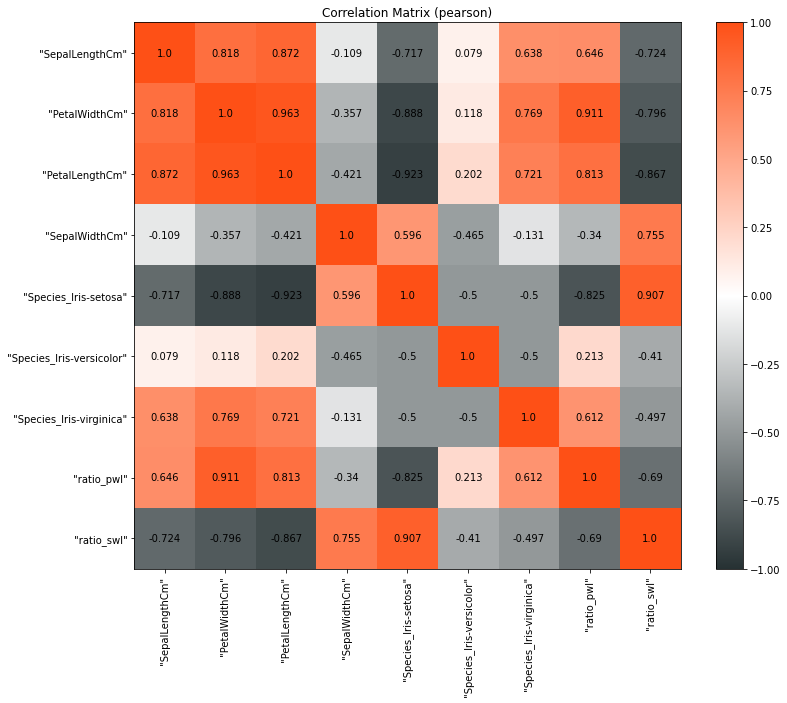

<object>

In [4]:
%matplotlib inline
iris.corr()

The Iris Setosa is highly linearly correlated with the Petal length and the Sepal ratio. We can see a perfect separation using the two features (the separation is also obvious using only one feature: the Petal Length)

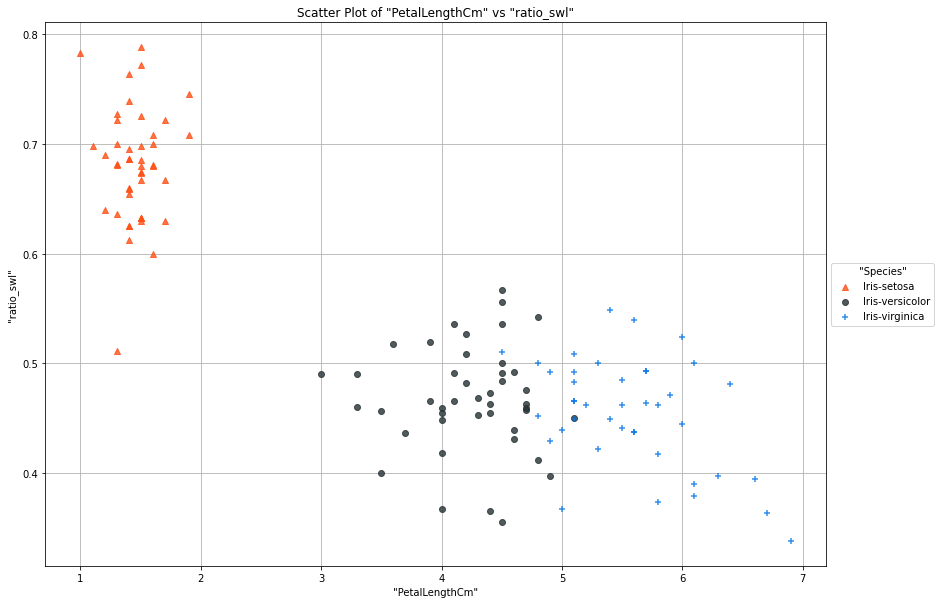

In [5]:
x = iris.scatter(columns = ["PetalLengthCm", "ratio_swl"], 
                 catcol = "Species")

We can also notice a clear linear separation between the Iris Versicolor and the Iris Virginica. However some flowers could be hardly classified and they will need more features.

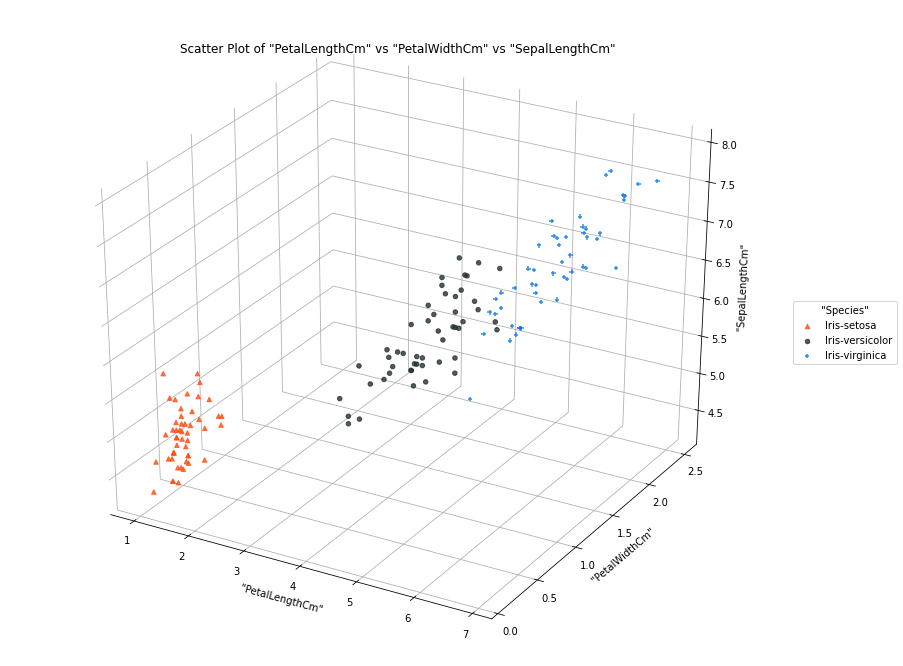

In [6]:
x = iris.scatter(columns = ["PetalLengthCm", 
                            "PetalWidthCm", 
                            "SepalLengthCm"], 
                 catcol = "Species")

The strategy is quite simple. We will use two linear SVC: one to classify the Iris Setosa first and one to classify the Iris Versicolor.

In [7]:
from verticapy.utilities import drop_view
drop_view("iris_clean")
x = iris.to_db("iris_clean")

The view iris_clean was successfully dropped.


## Machine Learning

Let's build the first Linear SVC to predict if the flower specie is Iris Setosa.

In [8]:
from verticapy.learn.svm import LinearSVC
from verticapy.learn.model_selection import cross_validate
from verticapy.utilities import drop_model

predictors = ["PetalLengthCm", "ratio_swl"]
response = "Species_Iris-setosa"
relation = "iris_clean"
drop_model("svc_setosa_iris")
model = LinearSVC("svc_setosa_iris")
cross_validate(model, relation, predictors, response)

The model svc_setosa_iris was successfully dropped.


<object>

The model is perfect as expected. <br>
Let's build it using the entire dataset.

In [9]:
model.fit(relation, predictors, response)



details
  predictor  |coefficient
-------------+-----------
  Intercept  |  1.38349  
petallengthcm| -0.84012  
  ratio_swl  |  1.32517  


call_string
SELECT svm_classifier('public.svc_setosa_iris', 'iris_clean', '"species_iris-setosa"', '"PetalLengthCm", "ratio_swl"'
USING PARAMETERS class_weights='1,1', C=1, max_iterations=100, intercept_mode='regularized', intercept_scaling=1, epsilon=0.0001);

Additional Info
       Name       |Value
------------------+-----
accepted_row_count| 150 
rejected_row_count|  0  
 iteration_count  |  7  

Let's plot the model to see the perfect separation.

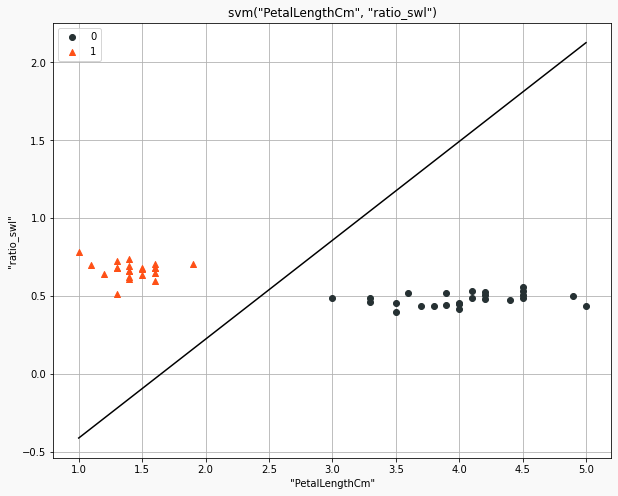

In [10]:
model.plot()

We can add the prediction in the Virtual Dataframe.

In [11]:
model.predict(iris, "setosa")

<object>  Name: iris, Number of rows: 150, Number of columns: 11

Let's create a model to classify the Iris Virginica.

In [12]:
from verticapy.learn.svm import LinearSVC
from verticapy.learn.model_selection import cross_validate
from verticapy.utilities import drop_model

predictors = ["PetalLengthCm", "SepalLengthCm", "SepalWidthCm", 
              "PetalWidthCm", "ratio_pwl", "ratio_swl"]
response = "Species_Iris-virginica"
relation = "iris_clean"
drop_model("svc_virginica_iris")
model = LinearSVC("svc_virginica_iris")
cross_validate(model, relation, predictors, response)

The model svc_virginica_iris was successfully dropped.


<object>

Excellent model too. Let's add it in the Virtual Dataframe.

In [13]:
model.fit(relation, predictors, response)
model.predict(iris, "virginica")

<object>  Name: iris, Number of rows: 150, Number of columns: 12

Let's evaluate our final model (combination of 2 Linear SVC)

In [14]:
iris.eval("prediction", 
          "CASE WHEN setosa THEN 'Iris-setosa' WHEN virginica THEN 'Iris-virginica' ELSE 'Iris-versicolor' END")
iris.eval("score", "(Species = prediction)::int")
iris["score"].avg()

0.98

Excellent model with an accuracy of 98% on an entirely balanced dataset.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.